# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.75957178095596

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
idxs = np.random.choice(X.shape[0], size=int(len(y)), replace = True)
X_bootstrap = X[idxs]
y_bootstrap = y[idxs]

In [ ]:
import numpy as np

def compute_bias_variance(regressor, X, y, num_runs=1000):
    sum_preds = np.zeros(len(y))
    squared_sum_preds = np.zeros(len(y))
    prediction_counts = np.zeros(len(y))
    errors = np.zeros(len(y))

    for _ in range(num_runs):
        idxs = np.random.choice(len(y), size=len(y), replace=True)
        out_of_bag = ~np.isin(np.arange(len(y)), idxs) #Прикольная штука, я ее нагуглила ~~~~~:)
        X_bootstrap = X[idxs]
        y_bootstrap = y[idxs]
        model = regressor.fit(X_bootstrap, y_bootstrap)
        y_pred = model.predict(X[out_of_bag])

        sum_preds[out_of_bag] += y_pred
        squared_sum_preds[out_of_bag] += y_pred**2
        prediction_counts[out_of_bag] += 1
        errors[out_of_bag] += (y_pred - y[out_of_bag]) ** 2

    idxs = prediction_counts > 0
    avg_preds = sum_preds[idxs] / prediction_counts[idxs]
    bias = np.mean((avg_preds - y[idxs]) ** 2)
    variance = np.mean((squared_sum_preds[idxs] / prediction_counts[idxs]) - avg_preds ** 2)
    error = np.mean(errors[idxs] / prediction_counts[idxs])

    return bias, variance, error


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
models = {
    "Линейная регрессия": LinearRegression(),
    "Решающее дерево": DecisionTreeRegressor(),
    "Случайный лес": RandomForestRegressor()
}
for name, model in models.items():
    bias, variance, error = compute_bias_variance(model, X, y, num_runs = 100)
    print(f"{name}: Смещение: {bias}, Разброс: {variance}, Ошибка: {error}")

Линейная регрессия: Смещение: 23.69556953181175, Разброс: 0.879287649877344, Ошибка: 24.57485718168909
Решающее дерево: Смещение: 10.709414326053999, Разброс: 13.271382519990784, Ошибка: 23.980796846044786
Случайный лес: Смещение: 10.589836993904107, Разброс: 2.1125631194557446, Ошибка: 12.70240011335985


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Линейная регрессия может находить только линейные зависимости между признаками, так что ее предсказания от реальных тарегтов достаточно далеки, и смещение большое, но при этом разброс очень маленький, потому что сложно значительно повертеть прямую)) И она не так склонна переобучиться и подностью подстроиться под выборку, как следующий метлд обучения. Ошибка большая, поскольку зависимость тут вряд ли линейная.

Решающие деревья с параметрами по умолчанию - не очень глубокие, так что у них не такое сильное смещение (потому что они уже могут находить нелинейные зависимости), как могло бы быть (если бы они, как могут деревья, полностью подстроились под обучающую выборку), но все же оно немаленькое, и при этом большой разброс, потому что деревья одинаковой глубины могут быть очень разными. Ошибка практически не уменьшилась, потому что деревья неглубокие.

В случайном лесе у нас получился очень маленький разброс, поскольку мы берем случайный набор признаков в каждом узле, и у нас получаются менее скоррелированные базовые модели, при этом смещение остается практически таким же, как и в предыдущем варианте, т.к. базовыми моделями все еще остаются деревья. Ну, и ошибка значительно меньше, так как тут используется комбинация нескольких моделей, меньше подвержены "подстраиванием" под выбросы и тд.

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
models = {
    "Бэггинг над линейной регрессией": BaggingRegressor(LinearRegression()),
    "Бэггинг над решающим деревом": BaggingRegressor(DecisionTreeRegressor()),
    "Бэггинг над случайным лесом": BaggingRegressor(RandomForestRegressor())
}
for name, model in models.items():
    bias, variance, error = compute_bias_variance(model, X, y, num_runs = 100)
    print(f"{name}: Смещение: {bias}, Разброс: {variance}, Ошибка: {error}")

Бэггинг над линейной регрессией: Смещение: 23.702917966827822, Разброс: 1.0403780365328807, Ошибка: 24.74329600336069
Бэггинг над решающим деревом: Смещение: 10.96369733495323, Разброс: 3.390187470755359, Ошибка: 14.353884805708585
Бэггинг над случайным лесом: Смещение: 11.620830592949122, Разброс: 1.448491884367297, Ошибка: 13.069322477316426


Разброс, правда, уменьшился везде, кроме линейной регрессии. Я думаю, это потому, что у нее и так разброс очень маленький, а мы усложняем алгоритм, и у нее ээ больше раздора))

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
from sklearn.utils import resample

In [22]:
def plot_predictions(regressor, X, y, num_test_objects = 10, num_runs = 100, title = "Предсказания модели"):
    """
    plot graphics described above
    """
    indices = np.random.choice(len(y), size = num_test_objects, replace = False)
    X_test, y_test = X[indices], y[indices]
    X_train, y_train = np.delete(X, indices, axis = 0), np.delete(y, indices, axis= 0)
    test_preds = np.zeros((num_test_objects, num_runs))
    for i in range(num_runs):
        X_bootstrap, y_bootstrap = resample(X_train, y_train, replace = True)
        model = regressor.fit(X_bootstrap, y_bootstrap)
        y_pred = model.predict(X_test)
        test_preds[:, i] = y_pred
    plt.figure(figsize=(12, 6))
    for i in range(num_test_objects):
        plt.scatter([i] * num_runs, test_preds[i, :], alpha=0.5)
        plt.scatter(i, y_test[i], color = 'black')

    plt.xlabel('Объект')
    plt.ylabel('Предикт')
    plt.title(title)
    plt.xticks(range(num_test_objects))
    plt.show()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

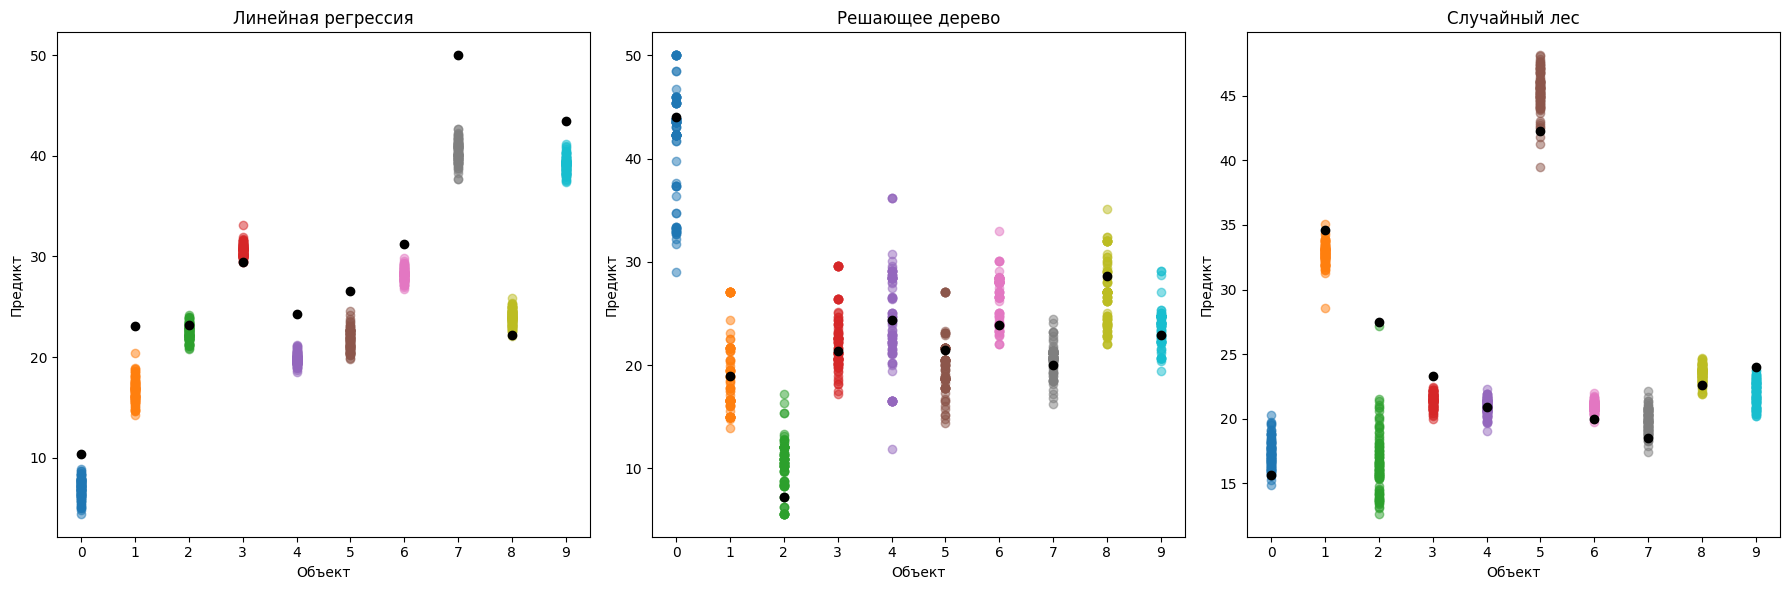

In [23]:
def plot_predictions(regressor, X, y, num_test_objects = 10, num_runs = 100, ax = None, title = "Предсказания модели"):
    indices = np.random.choice(len(y), size = num_test_objects, replace = False)
    X_test, y_test = X[indices], y[indices]
    X_train, y_train = np.delete(X, indices, axis = 0), np.delete(y, indices, axis = 0)
    test_preds = np.zeros((num_test_objects, num_runs))

    for i in range(num_runs):
        X_bootstrap, y_bootstrap = resample(X_train, y_train, replace = True)
        model = regressor.fit(X_bootstrap, y_bootstrap)
        y_pred = model.predict(X_test)
        test_preds[:, i] = y_pred # для i-й бутстрапной подвыборки сохраняем
    for i in range(num_test_objects):
        ax.scatter([i] * num_runs, test_preds[i, :], alpha = 0.5) # показываем вариацию на i-м объекте
        ax.scatter(i, y_test[i], color = 'black')
    ax.set_xlabel('Объект')
    ax.set_ylabel('Предикт')
    ax.set_title(title)
    ax.set_xticks(range(num_test_objects))
fig, axes = plt.subplots(1, 3, figsize = (18, 6))
regressors = [
    (LinearRegression(), "Линейная регрессия"),
    (DecisionTreeRegressor(), "Решающее дерево"),
    (RandomForestRegressor(), "Случайный лес")
]
for ax, (regressor, title) in zip(axes, regressors):
    plot_predictions(regressor, X, y, ax=ax, title=title)
plt.tight_layout()
plt.show()


__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__ На первом графике можно увидеть, что предсказанные значения даже не попадают в черные точки, то есть от реального таргета они очень отличаются - то есть смещение очень больше. Тем не менее они сгруппированы вместе, накладываются друг на друга, значит, разброс маленький.

В решающем дереве у нас многие точки попадают прямо в таргет (смещение не такое большое), но сами предсказания находятся друг от друга на расстоянии, часто не накладываются друг на друга - разброс большой.

В случайном лесе точки предсказаний больше попадают на черные точки, чем в линреге, но меньше, чем при решающем дереве - похожее на решающие деревья смещение, но разброс очень маленький, поскольку точки сгруппированы и находятся на маленьком расстоянии друг от друга.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving nesnewyear.jpg to nesnewyear.jpg


У нас в РЭШ был Новый год :)

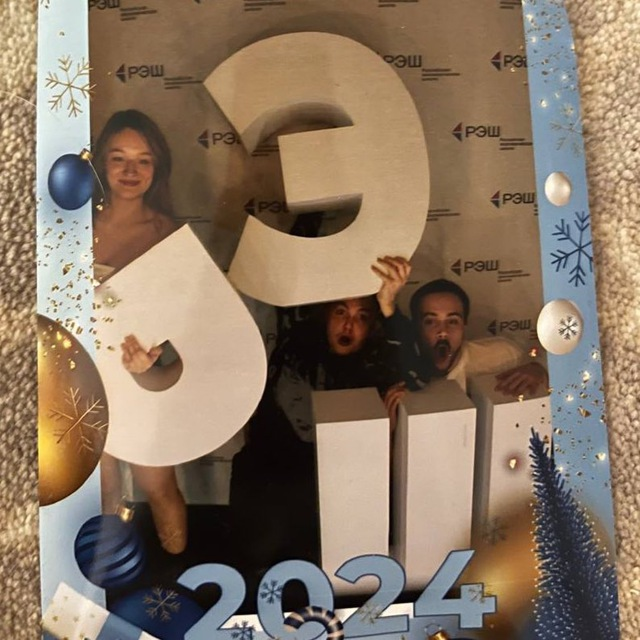

In [ ]:
Image('nesnewyear.jpg')